In [1]:
from __future__ import print_function
from time import time

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional
import numpy as np
from keras.callbacks import TensorBoard, EarlyStopping

import gc

import tensorflow as tf
from keras import backend as K

num_cores = 4

GPU = True
CPU = True
if GPU:
    num_GPU = 1
    num_CPU = 1
elif CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : num_CPU,
                                        'GPU' : num_GPU}
                       )

session = tf.Session(config=config)
K.set_session(session)


Using TensorFlow backend.


In [0]:

batch_size = 128  # Batch size for training.
epochs = 25  # Number of epochs to train for.
latent_dim = 512  # Latent dimensionality of the encoding space.

num_samples = 300000  # Number of samples to train on. Try upto 600000
max_encoder_seq_length = 80
max_decoder_seq_length = 80

data_path = '/content/datasets/en_train_normalised.csv'



In [3]:

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
lines = open(data_path).read().split('\n')
k=0

# mx1 = 0
# mx2 = 0
# in_sen = ''
# tg_sen = ''

#change no of samples to train on
for line in lines[1: min(num_samples, 25000)]:
    words = line.split(',')
    #print(len(words))
    input_text, target_text = ",".join(words[0:len(words)-1]), words[len(words)-1]
    
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
#     if len(input_text) > mx1 :
#         in_sen = input_text
#         mx1 = max(mx1, len(input_text))
    
#     if len(target_text) > mx2 :
#         tg_sen = target_text
#         mx2 = max(mx2, len(target_text))
            
    if k<10:
        print(words)
        print(input_text, target_text)
    k = k + 1
    
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

# print(mx1, mx2)
# print(in_sen, tg_sen)

['2006', 'two thousand six']
2006 	two thousand six

['IUCN', 'i u c n']
IUCN 	i u c n

['2007', 'two thousand seven']
2007 	two thousand seven

['2008', 'two thousand eight']
2008 	two thousand eight

['91', 'ninety one']
91 	ninety one

['04-Mar-14', 'the fourth of march twenty fourteen']
04-Mar-14 	the fourth of march twenty fourteen

['BC', 'b c']
BC 	b c

['3', 'three']
3 	three

['35', 'thirty five']
35 	thirty five

['"April 10', ' 2013"', 'april tenth twenty thirteen']
"April 10, 2013" 	april tenth twenty thirteen



In [4]:
            
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
# max_encoder_seq_length = max([len(txt) for txt in input_texts])
# max_decoder_seq_length = max([len(txt) for txt in target_texts])

print(input_characters[:5], target_characters[:5])
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)


[' ', '"', '#', '$', '%'] ['\t', '\n', ' ', "'", '-']
Number of samples: 24999
Number of unique input tokens: 427
Number of unique output tokens: 367
Max sequence length for inputs: 80
Max sequence length for outputs: 80


In [5]:
# char to int mapping

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

print(input_token_index, target_token_index)


{' ': 0, '"': 1, '#': 2, '$': 3, '%': 4, '&': 5, "'": 6, '(': 7, ')': 8, '+': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, 'A': 25, 'B': 26, 'C': 27, 'D': 28, 'E': 29, 'F': 30, 'G': 31, 'H': 32, 'I': 33, 'J': 34, 'K': 35, 'L': 36, 'M': 37, 'N': 38, 'O': 39, 'P': 40, 'Q': 41, 'R': 42, 'S': 43, 'T': 44, 'U': 45, 'V': 46, 'W': 47, 'X': 48, 'Y': 49, 'Z': 50, '_': 51, 'a': 52, 'b': 53, 'c': 54, 'd': 55, 'e': 56, 'f': 57, 'g': 58, 'h': 59, 'i': 60, 'j': 61, 'k': 62, 'l': 63, 'm': 64, 'n': 65, 'o': 66, 'p': 67, 'q': 68, 'r': 69, 's': 70, 't': 71, 'u': 72, 'v': 73, 'w': 74, 'x': 75, 'y': 76, 'z': 77, '~': 78, '£': 79, '¥': 80, 'ª': 81, '²': 82, '³': 83, 'º': 84, '¼': 85, '½': 86, 'é': 87, 'Ą': 88, 'Ś': 89, 'Ż': 90, 'ɔ': 91, 'ɛ': 92, 'ɪ': 93, 'ʻ': 94, 'ˈ': 95, 'ː': 96, 'Α': 97, 'Δ': 98, 'Ε': 99, 'Κ': 100, 'Λ': 101, 'Π': 102, 'Σ': 103, 'Χ': 104, 'α': 105, 'β': 106, 'γ': 107, 'δ': 108, 'ε': 109, 'η': 110,

In [6]:
gc.collect()

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')

decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32') 

print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(24999, 80, 427)
(24999, 80, 367)
(24999, 80, 367)


In [0]:
# we are assuming that a sequence will not have more than 100 chars
# max_decoder_seq_length = 100
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    #print(input_text, target_text)
    for t, char in enumerate(input_text):
        if t < max_encoder_seq_length:
            encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_target_data by one timestep
        if t < max_decoder_seq_length:
            decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0 and t < max_decoder_seq_length:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 22499 samples, validate on 2500 samples
Epoch 1/25
22499/22499 [==============================] - 81s 4ms/step - loss: 0.5152 - val_loss: 0.3769
Epoch 2/25
22499/22499 [==============================] - 80s 4ms/step - loss: 0.2790 - val_loss: 0.2240
Epoch 3/25
22499/22499 [==============================] - 80s 4ms/step - loss: 0.1734 - val_loss: 0.1499
Epoch 4/25
22499/22499 [==============================] - 80s 4ms/step - loss: 0.1349 - val_loss: 0.1325
Epoch 5/25
22499/22499 [==============================] - 80s 4ms/step - loss: 0.1194 - val_loss: 0.1189
Epoch 6/25
22499/22499 [==============================] - 80s 4ms/step - loss: 0.1093 - val_loss: 0.1105
Epoch 7/25
22499/22499 [==============================] - 80s 4ms/step - loss: 0.1022 - val_loss: 0.1057
Epoch 8/25
22499/2

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


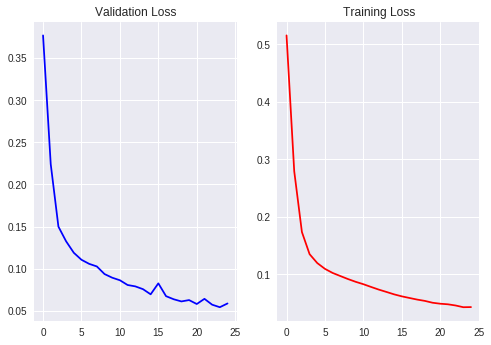

In [8]:

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

# modify early stopping to save machine state when val loss is min
early = EarlyStopping(monitor='val_loss', min_delta=0.00001, verbose=1, patience=3)


history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, 
                    validation_split=0.1, callbacks=[tensorboard, early])

# Save model
model.save('s2s_demorun_demo_1.h5')

# print statistical data
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].plot(history.history['val_loss'], 'b')
ax[0].set_title('Validation Loss')
ax[1].plot(history.history['loss'], 'r')
ax[1].set_title('Training Loss')

plt.show()

In [0]:

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())



In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
                    len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

-
Input sentence: 2006
Decoded sentence: two thousand six

-
Input sentence: IUCN
Decoded sentence: i u c n

-
Input sentence: 2007
Decoded sentence: two thousand seven

-
Input sentence: 2008
Decoded sentence: two thousand eight

-
Input sentence: 91
Decoded sentence: ninety one

-
Input sentence: 04-Mar-14
Decoded sentence: the fourth of june twenty twelve

-
Input sentence: BC
Decoded sentence: b c a

-
Input sentence: 3
Decoded sentence: three point one o

-
Input sentence: 35
Decoded sentence: thirty five thousand five hundred thirty seven

-
Input sentence: "April 10, 2013"
Decoded sentence: april twenty sixth twenty ten

-
Input sentence: 07-Aug-07
Decoded sentence: the seventh of april twenty twelve

-
Input sentence: 1987
Decoded sentence: nineteen eighty six

-
Input sentence: ALCS
Decoded sentence: a c a

-
Input sentence: 2
Decoded sentence: two

-
Input sentence: -
Decoded sentence: -

-
Input sentence: C.
Decoded sentence: c

-
Input sentence: J.
Decoded sentence: j

-
In

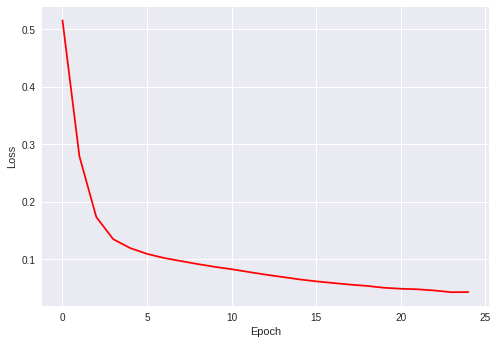

In [12]:
for seq_index in range(25):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

import gc

gc.collect()

from matplotlib import pyplot as plt

plt.plot(history.history['loss'], 'r')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()